In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

from getdist.densities import Density2D
import matplotlib.pyplot as plt
import numpy as np

from source import plotting, gp_emulator, utils

### GP ABC

This notebook illustrates how to use Gaussian process regression to emulate ABC likelihood estimates. We include the predictions of 128 different cosmological parameters of the __2D__ model presented in the paper.

We start by loading and plotting the predictions.

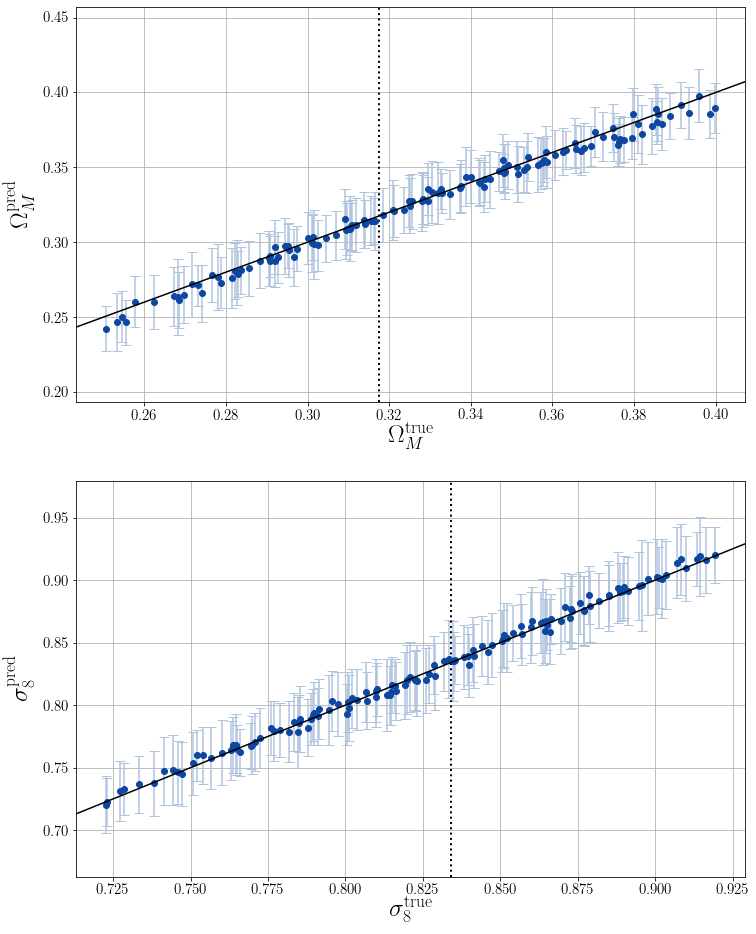

In [3]:
model_predictions = np.load("../data/2D_model_estimations.npz")
plotting.plot_true_vs_predicted(labels=model_predictions["labels"],
                                predictions=model_predictions["predictions"],
                                param_labels=["\Omega_M", "\sigma_8"],
                                fiducial_point=np.array([0.3175, 0.834]))


We proceed by calculating the ABC likelihood estimates and their uncertainties. We define the kernel and scale parameter as described in the paper.

In [4]:
loglike = utils.estimate_ABC_likelihood(predictions=model_predictions["predictions"],
                                        fisher_matrix=model_predictions["fisher_matrix"],
                                        observation=model_predictions["observation"],
                                        kernel="sigmoid",
                                        scale=0.35)

The first column of `loglike` contains the ABC log-likelihood estimates and the second column the estimated uncertainties. We can use this as input for the Gaussian process regression.

In [5]:
gp_emu = gp_emulator.VGP_Emu(X_init=model_predictions["labels"], Y_init=loglike, 
                             num_restarts=2, max_opt_iter=2500, normalize_Y=True,
                             mean_only=True, ARD=True, full_restart=False, 
                             learning_rate=0.05, parameter_noise_scale=0.05,
                             minimum_variance=1e-3)
predictor = gp_emu.get_noiseless_predictor()

╒═════════════════════════╤═══════════╤════════════════╤═════════╤═════════════╤═══════════════╤═════════╤══════════════════╕
│ name                    │ class     │ transform      │ prior   │ trainable   │ shape         │ dtype   │ value            │
╞═════════════════════════╪═══════════╪════════════════╪═════════╪═════════════╪═══════════════╪═════════╪══════════════════╡
│ VGP.kernel.variance     │ Parameter │ Softplus       │         │ True        │ ()            │ float64 │ 1.0              │
├─────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼───────────────┼─────────┼──────────────────┤
│ VGP.kernel.lengthscales │ Parameter │ Softplus       │         │ True        │ (2,)          │ float64 │ [1. 1.]          │
├─────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼───────────────┼─────────┼──────────────────┤
│ VGP.q_mu                │ Parameter │ Identity       │         │ False       │ (128, 1)      │ float64 │ [[0....    

100%|██████████| 2500/2500 [01:23<00:00, 29.88it/s, loss_val=376]   


Training the VGP model params...


100%|██████████| 2500/2500 [01:19<00:00, 31.38it/s, loss_val=376]  


We can use the trained GP emulator to plot the likelihood. Since we only have two dimensions, it is acutally not necessary to run a MCMC. We can simply evaluate the likelihood on a grid.

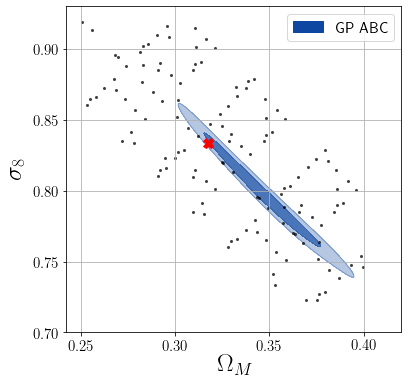

In [6]:
# priors and grid
priors = [np.linspace(0.27, 0.42, 256), np.linspace(0.7, 0.9, 256)]
om, s8 = np.meshgrid(priors[0], priors[1], indexing="ij")

# get the log_prob and shift (for stability)
ln_prob = predictor(np.stack([om.ravel(), s8.ravel()], axis=-1))
ln_prob -= np.max(ln_prob)
prob = np.exp(ln_prob)
density = Density2D(priors[0], priors[1], prob.reshape(om.shape).T)

# plot
plotting.plot_2D_density(density, scatter=model_predictions["labels"], 
                        xlabel="$\Omega_M$", ylabel="$\sigma_8$",
                        fiducial_point=np.array([0.3175, 0.834]),
                        label="GP ABC")